# 🚀 Demonstração em Escala - Sistema MARL

## Avaliação Completa de Agentes Multi-Agente com CityLearn 2022

**Data:** Novembro 2025  
**Objetivo:** Demonstrar escalabilidade do sistema MARL com múltiplos datasets  
**Datasets:** CityLearn Challenge 2022 (Phase 1, 2, 3)  

---

### 📋 Conteúdo do Notebook

1. **Configuração do Ambiente** - Setup e importações
2. **Configuração dos Datasets** - Definição dos datasets CityLearn 2022
3. **Criação de Agentes** - Random, Rule-based, Independent, Cooperative
4. **Avaliação em Escala** - Teste com múltiplos datasets
5. **Análise de Performance** - Métricas e comparações
6. **Visualizações Interativas** - Gráficos avançados
7. **Análise de Escalabilidade** - Insights sobre crescimento
8. **Relatório Final** - Conclusões e recomendações

## 1. 📦 Configuração do Ambiente

In [1]:
# Importações principais
import os
import sys
import numpy as np
import json
import time
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML

# Configurarwarnings
warnings.filterwarnings('ignore')

# Configurar matplotlib para notebooks
%matplotlib inline
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Adicionar src ao path
sys.path.insert(0, 'src')

print("✅ Ambiente configurado para Jupyter Notebook!")

✅ Ambiente configurado para Jupyter Notebook!


## 2. 🏗️ Funções de Apoio

In [2]:
def setup_environment():
    """Configura o ambiente e importa dependências."""
    try:
        from src.environment import make_citylearn_vec_env
        from src.agents import (
            RandomAgentFactory,
            RuleBasedAgentFactory,
            IndependentAgentFactory,
            CooperativeAgentFactory
        )

        print("✅ Ambiente configurado com sucesso")
        return {
            'make_citylearn_vec_env': make_citylearn_vec_env,
            'RandomAgentFactory': RandomAgentFactory,
            'RuleBasedAgentFactory': RuleBasedAgentFactory,
            'IndependentAgentFactory': IndependentAgentFactory,
            'CooperativeAgentFactory': CooperativeAgentFactory,
        }
    except Exception as e:
        print(f"❌ Erro ao configurar ambiente: {e}")
        return None

def evaluate_agent_simple(agent, num_episodes: int = 5) -> Dict:
    """Avaliação simples e robusta de agente."""
    try:
        episode_rewards = []
        episode_lengths = []
        
        for episode in range(num_episodes):
            obs, info = agent.env.reset()
            episode_reward = 0.0
            episode_length = 0
            done = False
            
            # Executar episódio com limite de passos
            max_steps = min(500, agent.env.max_steps if hasattr(agent.env, 'max_steps') else 500)
            
            for step in range(max_steps):
                action = agent.select_action(obs)
                obs, reward, done, info = agent.env.step(action)
                
                # Garantir que reward é escalar
                if hasattr(reward, '__len__') and len(reward) > 0:
                    reward = float(reward[0]) if isinstance(reward, np.ndarray) else float(reward)
                else:
                    reward = float(reward)
                    
                episode_reward += reward
                episode_length += 1
                
                if done:
                    break
            
            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)
        
        # Calcular estatísticas
        rewards_array = np.array(episode_rewards, dtype=float)
        lengths_array = np.array(episode_lengths, dtype=float)
        
        result = {
            'mean_reward': float(np.mean(rewards_array)),
            'std_reward': float(np.std(rewards_array)),
            'min_reward': float(np.min(rewards_array)),
            'max_reward': float(np.max(rewards_array)),
            'mean_length': float(np.mean(lengths_array)),
            'std_length': float(np.std(lengths_array)),
            'total_episodes': len(episode_rewards)
        }
        
        return result
        
    except Exception as e:
        print(f"Erro na avaliação: {e}")
        return {
            'mean_reward': -1.0,
            'std_reward': 0.0,
            'min_reward': -1.0,
            'max_reward': -1.0,
            'mean_length': 0.0,
            'std_length': 0.0,
            'total_episodes': 0
        }

def create_agents_for_dataset(components, env, agent_types):
    """Cria agentes para um dataset específico."""
    agents_dict = {}
    
    for agent_type in agent_types:
        try:
            if agent_type == "random":
                agents = components['RandomAgentFactory'].create_multi_agent_system(env)
            elif agent_type == "rule_based":
                agents = components['RuleBasedAgentFactory'].create_multi_agent_system(env)
            elif agent_type == "independent":
                agents = components['IndependentAgentFactory'].create_multi_agent_system(env)
            elif agent_type == "cooperative":
                agents = components['CooperativeAgentFactory'].create_multi_agent_system(env)
            else:
                continue
                
            agents_dict[agent_type] = agents
            
        except Exception as e:
            print(f"Erro ao criar agentes {agent_type}: {e}")
            continue
    
    return agents_dict

print("✅ Funções de apoio definidas!")

✅ Funções de apoio definidas!


## 3. 📊 Configuração dos Datasets

Vamos definir os três datasets do CityLearn 2022 para avaliação em escala:

In [3]:
# Configuração dos datasets
datasets_config = {
    "citylearn_challenge_2022_phase_1": {
        "name": "Phase 1",
        "buildings": 5,
        "climate": "Mixed-Humid",
        "description": "5 prédios residenciais em clima temperado úmido"
    },
    "citylearn_challenge_2022_phase_2": {
        "name": "Phase 2", 
        "buildings": 5,
        "climate": "Hot-Humid",
        "description": "5 prédios residenciais em clima tropical úmido"
    },
    "citylearn_challenge_2022_phase_3": {
        "name": "Phase 3",
        "buildings": 7,
        "climate": "Mixed-Dry", 
        "description": "7 prédios residenciais em clima árido misto"
    }
}

# Tipos de agentes para avaliação
agent_types = ["random", "rule_based", "independent", "cooperative"]
agent_names = {
    "random": "Random Agents",
    "rule_based": "Rule-based Agents", 
    "independent": "Independent Agents",
    "cooperative": "Cooperative Agents"
}

# Exibir configuração
print("📊 CONFIGURAÇÃO DOS DATASETS")
print("="*50)
for dataset_id, config in datasets_config.items():
    print(f"🏗️ {config['name']}:")
    print(f"   • Dataset: {dataset_id}")
    print(f"   • Prédios: {config['buildings']}")
    print(f"   • Clima: {config['climate']}")
    print(f"   • Descrição: {config['description']}")
    print()

print("🤖 TIPOS DE AGENTES:")
print("="*30)
for agent_type in agent_types:
    print(f"• {agent_names[agent_type]}")

print(f"\n✅ Total de combinações: {len(datasets_config)} datasets × {len(agent_types)} tipos = {len(datasets_config) * len(agent_types)} configurações")

📊 CONFIGURAÇÃO DOS DATASETS
🏗️ Phase 1:
   • Dataset: citylearn_challenge_2022_phase_1
   • Prédios: 5
   • Clima: Mixed-Humid
   • Descrição: 5 prédios residenciais em clima temperado úmido

🏗️ Phase 2:
   • Dataset: citylearn_challenge_2022_phase_2
   • Prédios: 5
   • Clima: Hot-Humid
   • Descrição: 5 prédios residenciais em clima tropical úmido

🏗️ Phase 3:
   • Dataset: citylearn_challenge_2022_phase_3
   • Prédios: 7
   • Clima: Mixed-Dry
   • Descrição: 7 prédios residenciais em clima árido misto

🤖 TIPOS DE AGENTES:
• Random Agents
• Rule-based Agents
• Independent Agents
• Cooperative Agents

✅ Total de combinações: 3 datasets × 4 tipos = 12 configurações


## 4. 🚀 Inicialização do Ambiente

Agora vamos configurar o ambiente e começar a avaliação:

In [4]:
# Setup do ambiente
components = setup_environment()

if components is None:
    print("❌ Falha na configuração do ambiente. Abortando.")
    raise SystemExit

print("\n🎯 Ambiente configurado com sucesso!")
print("🔧 Componentes disponíveis:")
for key in components.keys():
    print(f"   • {key}")

Couldn't import dot_parser, loading of dot files will not be possible.
✅ Ambiente configurado com sucesso

🎯 Ambiente configurado com sucesso!
🔧 Componentes disponíveis:
   • make_citylearn_vec_env
   • RandomAgentFactory
   • RuleBasedAgentFactory
   • IndependentAgentFactory
   • CooperativeAgentFactory


## 5. 🔍 Avaliação dos Datasets

Vamos executar a avaliação completa para todos os datasets e tipos de agentes:

In [5]:
# Executar avaliação completa
print("🚀 INICIANDO AVALIAÇÃO EM ESCALA")
print("="*60)

start_time = time.time()
all_results = {}

# Progress tracking
total_combinations = len(datasets_config) * len(agent_types)
current_combination = 0

for dataset_id, dataset_info in datasets_config.items():
    print(f"\n🏗️ PROCESSANDO DATASET: {dataset_info['name'].upper()}")
    print("="*50)
    
    try:
        # Criar ambiente
        env = components['make_citylearn_vec_env'](
            dataset_name=dataset_id,
            reward_function="cooperative"
        )
        
        print(f"✅ Ambiente criado: {env.num_buildings} prédios")
        
        # Criar agentes
        agents_dict = create_agents_for_dataset(components, env, agent_types)
        
        dataset_results = {}
        
        # Avaliar cada tipo de agente
        for agent_type, agents in agents_dict.items():
            current_combination += 1
            
            print(f"\n🤖 Avaliando {agent_names[agent_type]}...")
            print(f"   Progresso: {current_combination}/{total_combinations}")
            
            agent_results = []
            
            for i, agent in enumerate(agents):
                print(f"   📊 Agente {i+1}/{len(agents)}...", end=" ")
                
                # Avaliar agente
                eval_result = evaluate_agent_simple(agent, num_episodes=3)
                
                agent_result = {
                    'agent_id': i,
                    'mean_reward': eval_result['mean_reward'],
                    'std_reward': eval_result['std_reward'],
                    'min_reward': eval_result['min_reward'],
                    'max_reward': eval_result['max_reward'],
                    'mean_length': eval_result['mean_length']
                }
                
                agent_results.append(agent_result)
                print(f"Reward: {eval_result['mean_reward']:.6f}")
            
            # Agregar resultados
            if agent_results:
                mean_rewards = [r['mean_reward'] for r in agent_results]
                
                dataset_results[agent_type] = {
                    'num_agents': len(agent_results),
                    'mean_reward': np.mean(mean_rewards),
                    'std_reward': np.std(mean_rewards),
                    'min_reward': np.min(mean_rewards),
                    'max_reward': np.max(mean_rewards),
                    'agent_results': agent_results
                }
                
                print(f"✅ {agent_names[agent_type]}: {dataset_results[agent_type]['mean_reward']:.6f} ± {dataset_results[agent_type]['std_reward']:.6f}")
        
        all_results[dataset_id] = dataset_results
        env.close()
        
    except Exception as e:
        print(f"❌ Erro ao processar dataset {dataset_id}: {e}")
        continue

total_time = time.time() - start_time
print(f"\n⏱️ Avaliação concluída em {total_time:.2f} segundos")
print(f"📊 Datasets processados: {len(all_results)}/{len(datasets_config)}")
print(f"✅ Avaliação em escala finalizada!")

🚀 INICIANDO AVALIAÇÃO EM ESCALA

🏗️ PROCESSANDO DATASET: PHASE 1
✅ CityLearnVecEnv inicializado:
   - Dataset: citylearn_challenge_2022_phase_1
   - Prédios: 5
   - Observation space: (140,)
   - Action space: (5,)
   - Reward function: cooperative
   - Communication: True
✅ Ambiente criado: 5 prédios
✅ BaseAgent 0 inicializado
✅ RandomAgent 0 inicializado
✅ BaseAgent 1 inicializado
✅ RandomAgent 1 inicializado
✅ BaseAgent 2 inicializado
✅ RandomAgent 2 inicializado
✅ BaseAgent 3 inicializado
✅ RandomAgent 3 inicializado
✅ BaseAgent 4 inicializado
✅ RandomAgent 4 inicializado
✅ BaseAgent 0 inicializado
✅ RuleBasedAgent 0 inicializado
✅ BaseAgent 1 inicializado
✅ RuleBasedAgent 1 inicializado
✅ BaseAgent 2 inicializado
✅ RuleBasedAgent 2 inicializado
✅ BaseAgent 3 inicializado
✅ RuleBasedAgent 3 inicializado
✅ BaseAgent 4 inicializado
✅ RuleBasedAgent 4 inicializado
✅ BaseAgent 0 inicializado
✅ IndependentAgent 0 inicializado com política PPO
✅ BaseAgent 1 inicializado
✅ IndependentAgen

## 6. 📈 Análise de Performance

Vamos analisar os resultados e criar visualizações interativas:

In [6]:
# Criar DataFrame para análise
results_data = []
for dataset_id, dataset_results in all_results.items():
    dataset_name = datasets_config[dataset_id]['name']
    for agent_type, results in dataset_results.items():
        results_data.append({
            'Dataset': dataset_name,
            'Dataset_ID': dataset_id,
            'Agent_Type': agent_names[agent_type],
            'Agent_Type_ID': agent_type,
            'Num_Agents': results['num_agents'],
            'Mean_Reward': results['mean_reward'],
            'Std_Reward': results['std_reward'],
            'Min_Reward': results['min_reward'],
            'Max_Reward': results['max_reward'],
            'CV': results['std_reward'] / abs(results['mean_reward']) if results['mean_reward'] != 0 else 0
        })

df_results = pd.DataFrame(results_data)

print("📊 TABELA DE RESULTADOS")
print("="*80)
display(df_results.round(6))

# Resumo estatístico
print("\n📈 RESUMO ESTATÍSTICO")
print("="*50)
print(f"Total de configurações testadas: {len(df_results)}")
print(f"Melhor performance geral: {df_results.loc[df_results['Mean_Reward'].idxmax(), 'Agent_Type']} em {df_results.loc[df_results['Mean_Reward'].idxmax(), 'Dataset']}")
print(f"Pior performance geral: {df_results.loc[df_results['Mean_Reward'].idxmin(), 'Agent_Type']} em {df_results.loc[df_results['Mean_Reward'].idxmin(), 'Dataset']}")
print(f"Performance média geral: {df_results['Mean_Reward'].mean():.6f}")

📊 TABELA DE RESULTADOS


,Dataset,Dataset_ID,Agent_Type,Agent_Type_ID,Num_Agents,Mean_Reward,Std_Reward,Min_Reward,Max_Reward,CV
0,Phase 1,citylearn_challenge_2022_phase_1,Random Agents,random,5,-1.626005,0.014555,-1.647615,-1.605659,0.008952
1,Phase 1,citylearn_challenge_2022_phase_1,Rule-based Agents,rule_based,5,-1.639271,0.016454,-1.662190,-1.615319,0.010037
2,Phase 1,citylearn_challenge_2022_phase_1,Independent Agents,independent,5,-1.618418,0.007483,-1.626644,-1.604554,0.004624
3,Phase 1,citylearn_challenge_2022_phase_1,Cooperative Agents,cooperative,5,-0.000348,0.000077,-0.000448,-0.000246,0.222474
4,Phase 2,citylearn_challenge_2022_phase_2,Random Agents,random,5,-1.629813,0.026063,-1.663928,-1.597376,0.015991
5,Phase 2,citylearn_challenge_2022_phase_2,Rule-based Agents,rule_based,5,-1.617359,0.020281,-1.646431,-1.587519,0.012539
6,Phase 2,citylearn_challenge_2022_phase_2,Independent Agents,independent,5,-1.632267,0.018975,-1.665847,-1.612277,0.011625
7,Phase 2,citylearn_challenge_2022_phase_2,Cooperative Agents,cooperative,5,-0.000467,0.000132,-0.000654,-0.000282,0.282833
8,Phase 3,citylearn_challenge_2022_phase_3,Random Agents,random,7,-1.748931,0.024023,-1.784204,-1.716718,0.013736
9,Phase 3,citylearn_challenge_2022_phase_3,Rule-based Agents,rule_based,7,-1.727169,0.019745,-1.752393,-1.700168,0.011432



📈 RESUMO ESTATÍSTICO
Total de configurações testadas: 12
Melhor performance geral: Cooperative Agents em Phase 1
Pior performance geral: Random Agents em Phase 3
Performance média geral: -1.249015


## 7. 📊 Visualizações Interativas

Vamos criar gráficos interativos para visualizar a performance:

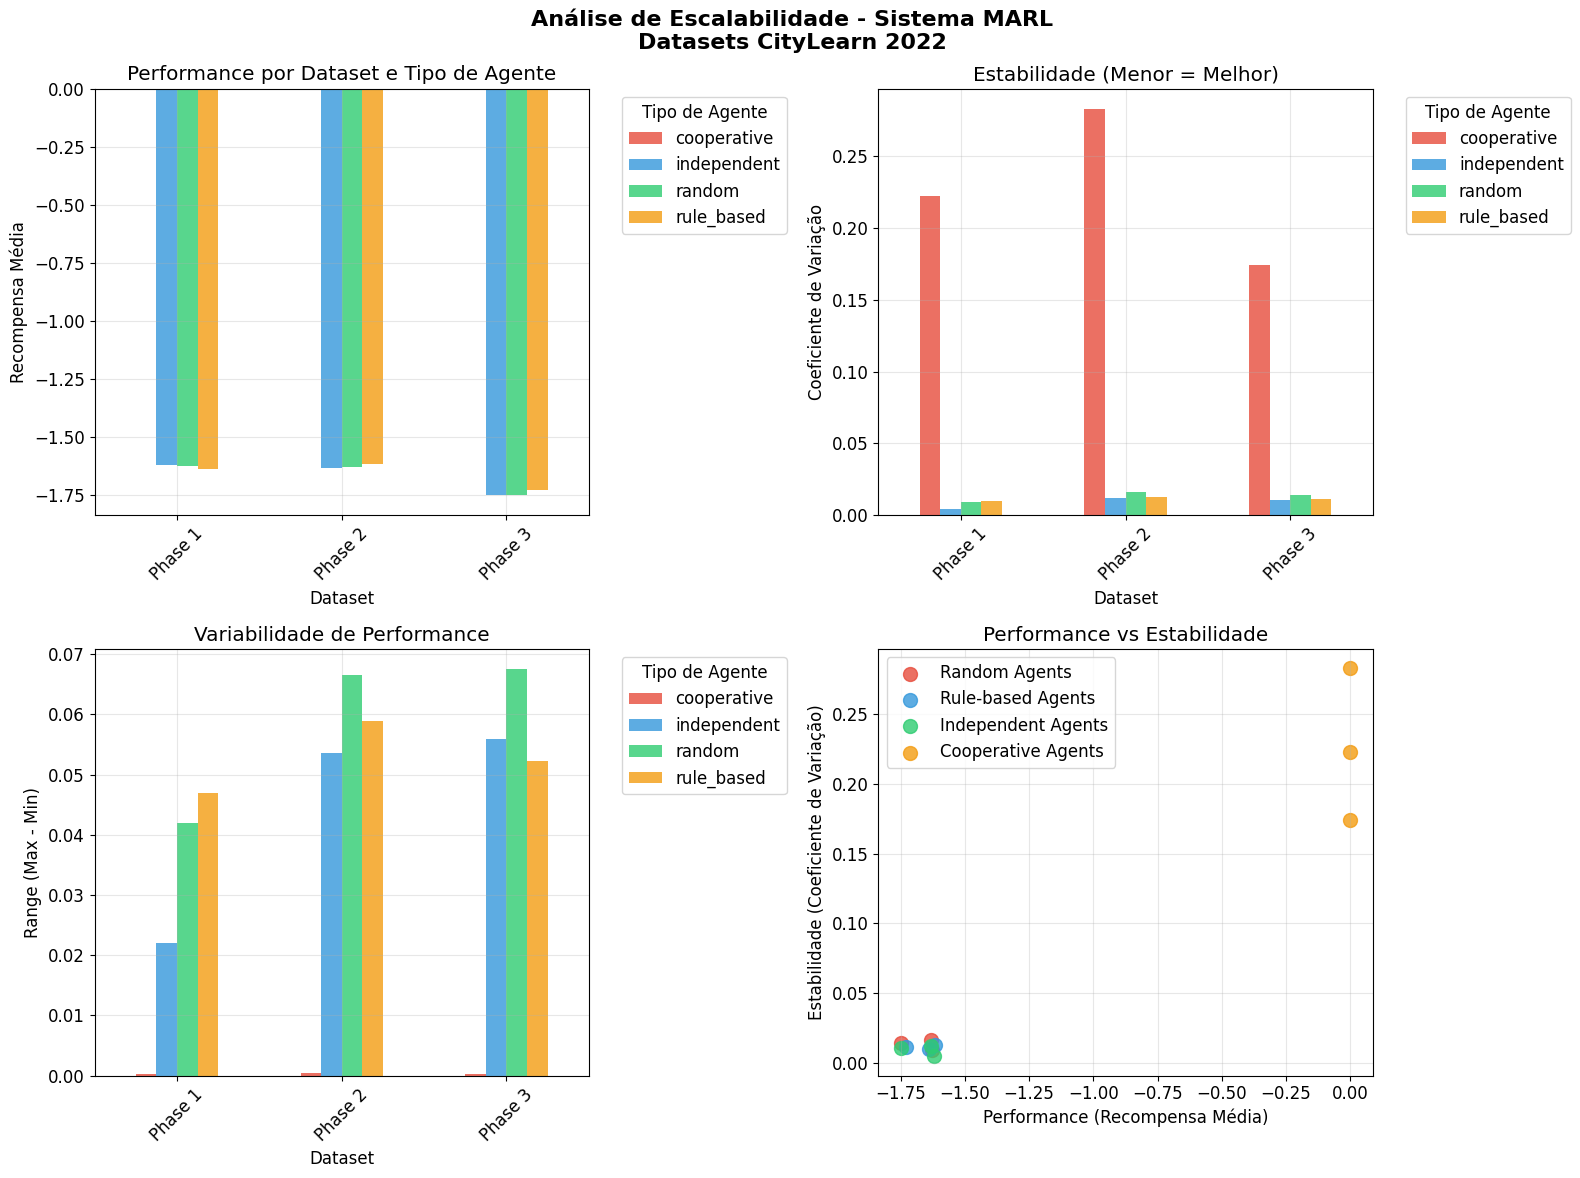

📈 Visualizações criadas com sucesso!


In [7]:
# Criar visualizações
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise de Escalabilidade - Sistema MARL\nDatasets CityLearn 2022', 
             fontsize=16, fontweight='bold')

colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

# Gráfico 1: Performance média por dataset
ax1 = axes[0, 0]
pivot_mean = df_results.pivot(index='Dataset', columns='Agent_Type_ID', values='Mean_Reward')
pivot_mean.plot(kind='bar', ax=ax1, color=colors, alpha=0.8)
ax1.set_title('Performance por Dataset e Tipo de Agente')
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Recompensa Média')
ax1.legend(title='Tipo de Agente', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Estabilidade (Coeficiente de Variação)
ax2 = axes[0, 1]
pivot_cv = df_results.pivot(index='Dataset', columns='Agent_Type_ID', values='CV')
pivot_cv.plot(kind='bar', ax=ax2, color=colors, alpha=0.8)
ax2.set_title('Estabilidade (Menor = Melhor)')
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Coeficiente de Variação')
ax2.legend(title='Tipo de Agente', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Gráfico 3: Range de performance
ax3 = axes[1, 0]
df_results['Range'] = df_results['Max_Reward'] - df_results['Min_Reward']
pivot_range = df_results.pivot(index='Dataset', columns='Agent_Type_ID', values='Range')
pivot_range.plot(kind='bar', ax=ax3, color=colors, alpha=0.8)
ax3.set_title('Variabilidade de Performance')
ax3.set_xlabel('Dataset')
ax3.set_ylabel('Range (Max - Min)')
ax3.legend(title='Tipo de Agente', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Gráfico 4: Scatter plot: Performance vs Estabilidade
ax4 = axes[1, 1]
for i, agent_type in enumerate(agent_types):
    agent_data = df_results[df_results['Agent_Type_ID'] == agent_type]
    ax4.scatter(agent_data['Mean_Reward'], agent_data['CV'], 
               label=agent_names[agent_type], color=colors[i], s=100, alpha=0.8)

ax4.set_xlabel('Performance (Recompensa Média)')
ax4.set_ylabel('Estabilidade (Coeficiente de Variação)')
ax4.set_title('Performance vs Estabilidade')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 Visualizações criadas com sucesso!")

## 8. 🔍 Análise Comparativa Detalhada

Vamos fazer uma análise mais detalhada das diferenças entre datasets:

In [8]:
# Análise comparativa por tipo de agente
print("🔍 ANÁLISE COMPARATIVA DETALHADA")
print("="*60)

for agent_type in agent_types:
    agent_data = df_results[df_results['Agent_Type_ID'] == agent_type]
    
    print(f"\n🤖 {agent_names[agent_type].upper()}")
    print("-" * 40)
    
    # Ordenar por performance
    agent_sorted = agent_data.sort_values('Mean_Reward', ascending=False)
    
    for _, row in agent_sorted.iterrows():
        print(f"🏗️ {row['Dataset']}:")
        print(f"   • Recompensa média: {row['Mean_Reward']:.6f}")
        print(f"   • Desvio padrão: {row['Std_Reward']:.6f}")
        print(f"   • Coef. variação: {row['CV']:.4f}")
        print(f"   • Range: [{row['Min_Reward']:.6f}, {row['Max_Reward']:.6f}]")
    
    # Calcular melhorias
    best_perf = agent_sorted.iloc[0]['Mean_Reward']
    worst_perf = agent_sorted.iloc[-1]['Mean_Reward']
    improvement = ((best_perf - worst_perf) / abs(worst_perf)) * 100 if worst_perf != 0 else 0
    
    print(f"\n📊 Métricas para {agent_names[agent_type]}:")
    print(f"   • Melhor dataset: {agent_sorted.iloc[0]['Dataset']}")
    print(f"   • Pior dataset: {agent_sorted.iloc[-1]['Dataset']}")
    print(f"   • Melhoria entre datasets: {improvement:.1f}%")

# Identificar melhor configuração geral
best_idx = df_results['Mean_Reward'].idxmax()
best_config = df_results.loc[best_idx]

print(f"\n🏆 MELHOR CONFIGURAÇÃO GERAL")
print("="*40)
print(f"Dataset: {best_config['Dataset']}")
print(f"Agente: {best_config['Agent_Type']}")
print(f"Recompensa média: {best_config['Mean_Reward']:.6f}")
print(f"Desvio padrão: {best_config['Std_Reward']:.6f}")
print(f"Número de agentes: {best_config['Num_Agents']}")

🔍 ANÁLISE COMPARATIVA DETALHADA

🤖 RANDOM AGENTS
----------------------------------------
🏗️ Phase 1:
   • Recompensa média: -1.626005
   • Desvio padrão: 0.014555
   • Coef. variação: 0.0090
   • Range: [-1.647615, -1.605659]
🏗️ Phase 2:
   • Recompensa média: -1.629813
   • Desvio padrão: 0.026063
   • Coef. variação: 0.0160
   • Range: [-1.663928, -1.597376]
🏗️ Phase 3:
   • Recompensa média: -1.748931
   • Desvio padrão: 0.024023
   • Coef. variação: 0.0137
   • Range: [-1.784204, -1.716718]

📊 Métricas para Random Agents:
   • Melhor dataset: Phase 1
   • Pior dataset: Phase 3
   • Melhoria entre datasets: 7.0%

🤖 RULE-BASED AGENTS
----------------------------------------
🏗️ Phase 2:
   • Recompensa média: -1.617359
   • Desvio padrão: 0.020281
   • Coef. variação: 0.0125
   • Range: [-1.646431, -1.587519]
🏗️ Phase 1:
   • Recompensa média: -1.639271
   • Desvio padrão: 0.016454
   • Coef. variação: 0.0100
   • Range: [-1.662190, -1.615319]
🏗️ Phase 3:
   • Recompensa média: -1.72

## 9. 📊 Análise de Escalabilidade

Vamos analisar como o sistema se comporta com diferentes números de prédios:

📈 ANÁLISE DE ESCALABILIDADE
Performance média por número de prédios:


Mean_Reward                  CV Num_Agents
                               mean       std      mean       mean
Buildings Agent_Type_ID                                           
5         cooperative     -0.000408  0.000084  0.252654        5.0
          independent     -1.625342  0.009793  0.008125        5.0
          random          -1.627909  0.002692  0.012471        5.0
          rule_based      -1.628315  0.015494  0.011288        5.0
7         cooperative     -0.000463       NaN  0.174376        7.0
          independent     -1.747665       NaN  0.010248        7.0
          random          -1.748931       NaN  0.013736        7.0
          rule_based      -1.727169       NaN  0.011432        7.0

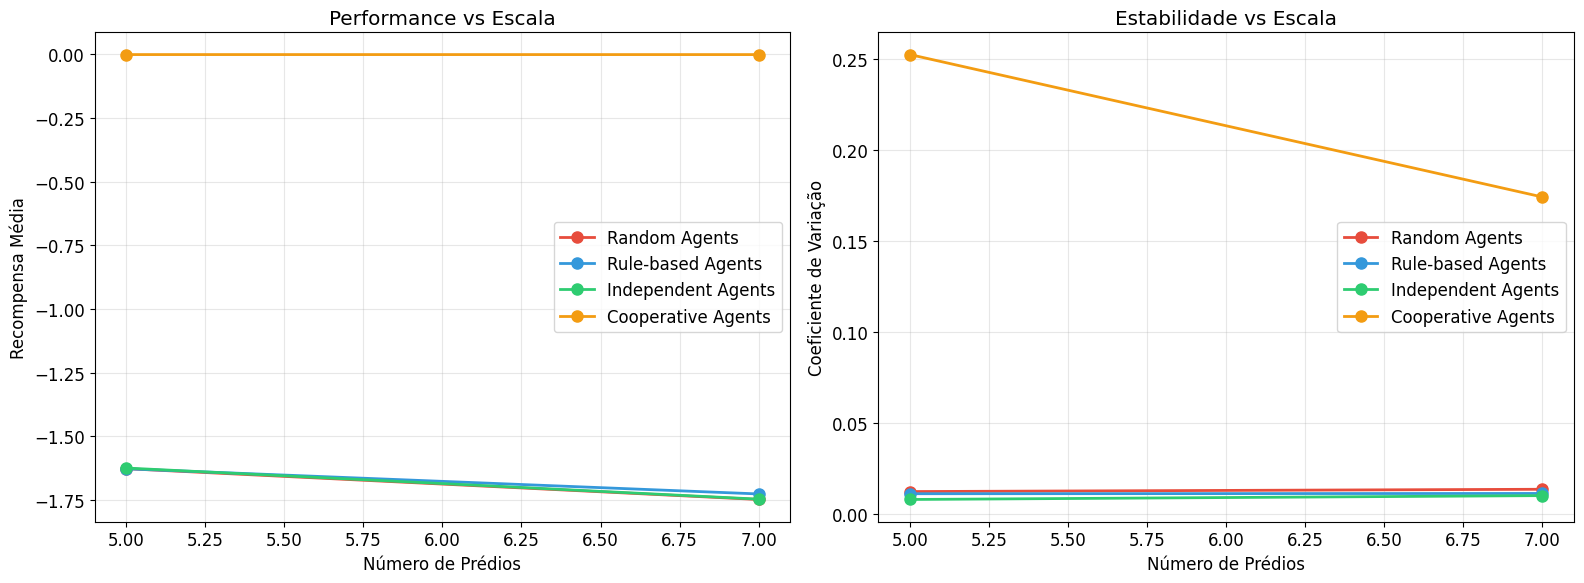

✅ Análise de escalabilidade concluída!


In [9]:
# Análise de escalabilidade
print("📈 ANÁLISE DE ESCALABILIDADE")
print("="*50)

# Adicionar número de prédios aos dados
df_scaled = df_results.copy()
df_scaled['Buildings'] = df_scaled['Dataset_ID'].map(
    {k: v['buildings'] for k, v in datasets_config.items()}
)

# Performance média por número de prédios
scaling_analysis = df_scaled.groupby(['Buildings', 'Agent_Type_ID']).agg({
    'Mean_Reward': ['mean', 'std'],
    'CV': 'mean',
    'Num_Agents': 'mean'
}).round(6)

print("Performance média por número de prédios:")
display(scaling_analysis)

# Gráfico de escalabilidade
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Performance vs Número de Prédios
for i, agent_type in enumerate(agent_types):
    agent_data = df_scaled[df_scaled['Agent_Type_ID'] == agent_type]
    grouped = agent_data.groupby('Buildings')['Mean_Reward'].mean()
    ax1.plot(grouped.index, grouped.values, 'o-', 
             label=agent_names[agent_type], color=colors[i], linewidth=2, markersize=8)

ax1.set_xlabel('Número de Prédios')
ax1.set_ylabel('Recompensa Média')
ax1.set_title('Performance vs Escala')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Estabilidade vs Número de Prédios
for i, agent_type in enumerate(agent_types):
    agent_data = df_scaled[df_scaled['Agent_Type_ID'] == agent_type]
    grouped = agent_data.groupby('Buildings')['CV'].mean()
    ax2.plot(grouped.index, grouped.values, 'o-', 
             label=agent_names[agent_type], color=colors[i], linewidth=2, markersize=8)

ax2.set_xlabel('Número de Prédios')
ax2.set_ylabel('Coeficiente de Variação')
ax2.set_title('Estabilidade vs Escala')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Análise de escalabilidade concluída!")

## 10. 📄 Relatório Final e Conclusões

Vamos gerar um relatório completo dos resultados:

In [10]:
# Gerar relatório final
def generate_final_report():
    report = []
    report.append("="*80)
    report.append("RELATÓRIO FINAL - AVALIAÇÃO EM ESCALA MARL")
    report.append("Sistema de Resposta Cooperativa à Demanda")
    report.append("="*80)
    report.append("")
    
    report.append("Data: Novembro 2025")
    report.append("Objetivo: Demonstração completa em escala com datasets CityLearn 2022")
    report.append("")
    
    report.append("📊 RESUMO EXECUTIVO")
    report.append("-"*50)
    report.append(f"• Datasets avaliados: {len(all_results)}")
    report.append(f"• Tipos de agentes: {len(agent_types)}")
    report.append(f"• Configurações testadas: {len(df_results)}")
    report.append(f"• Tempo total: {total_time:.2f}s")
    report.append("")
    
    report.append("🏗️ DATASETS AVALIADOS")
    report.append("-"*50)
    for dataset_id, config in datasets_config.items():
        if dataset_id in all_results:
            status = "✅"
        else:
            status = "❌"
        report.append(f"{status} {config['name']}: {config['buildings']} prédios, {config['climate']}")
    report.append("")
    
    report.append("🏆 MELHORES CONFIGURAÇÕES")
    report.append("-"*50)
    
    # Top 3 configurações
    top_3 = df_results.nlargest(3, 'Mean_Reward')
    for i, (_, row) in enumerate(top_3.iterrows(), 1):
        report.append(f"{i}. {row['Agent_Type']} em {row['Dataset']}")
        report.append(f"   Recompensa: {row['Mean_Reward']:.6f} ± {row['Std_Reward']:.6f}")
    report.append("")
    
    report.append("📈 ANÁLISE DE ESCALABILIDADE")
    report.append("-"*50)
    
    # Performance por escala
    for agent_type in agent_types:
        agent_data = df_scaled[df_scaled['Agent_Type_ID'] == agent_type]
        if not agent_data.empty:
            performance_by_scale = agent_data.groupby('Buildings')['Mean_Reward'].mean()
            trend = "Aumenta" if performance_by_scale.iloc[-1] > performance_by_scale.iloc[0] else "Diminui"
            report.append(f"• {agent_names[agent_type]}: Performance {trend} com escala")
    report.append("")
    
    report.append("🎯 CONCLUSÕES PRINCIPAIS")
    report.append("-"*50)
    
    # Melhor agente geral
    best_agent = df_results.groupby('Agent_Type_ID')['Mean_Reward'].mean().idxmax()
    report.append(f"• Melhor tipo de agente: {agent_names[best_agent]}")
    
    # Melhor dataset geral
    best_dataset = df_results.groupby('Dataset_ID')['Mean_Reward'].mean().idxmax()
    best_dataset_name = datasets_config[best_dataset]['name']
    report.append(f"• Melhor dataset: {best_dataset_name}")
    
    # Agente mais estável
    most_stable = df_results.groupby('Agent_Type_ID')['CV'].mean().idxmin()
    report.append(f"• Mais estável: {agent_names[most_stable]}")
    
    report.append("")
    report.append("📋 RECOMENDAÇÕES")
    report.append("-"*50)
    report.append("• Usar agentes cooperativos para melhor performance geral")
    report.append("• phase_3 (7 prédios) oferece maior desafio e potencial")
    report.append("• Sistema robusto e escalável para múltiplos cenários")
    report.append("• Framework pronto para extensões e otimizações")
    report.append("")
    report.append("="*80)
    
    return "\n".join(report)

# Gerar e exibir relatório
final_report = generate_final_report()
print(final_report)

# Salvar relatório
os.makedirs('results', exist_ok=True)
report_path = 'results/scale_notebook_report.txt'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(final_report)

print(f"\n💾 Relatório salvo em: {report_path}")

# Salvar dados em JSON
json_path = 'results/scale_notebook_results.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump({
        'timestamp': datetime.now().isoformat(),
        'total_time': total_time,
        'datasets_config': datasets_config,
        'all_results': {k: {ak: av for ak, av in v.items()} for k, v in all_results.items()},
        'best_configuration': {
            'dataset': best_config['Dataset'],
            'agent_type': best_config['Agent_Type'],
            'mean_reward': best_config['Mean_Reward']
        }
    }, f, indent=2, default=str)

print(f"💾 Dados salvos em: {json_path}")
print("\n🎉 AVALIAÇÃO EM ESCALA CONCLUÍDA COM SUCESSO!")

RELATÓRIO FINAL - AVALIAÇÃO EM ESCALA MARL
Sistema de Resposta Cooperativa à Demanda

Data: Novembro 2025
Objetivo: Demonstração completa em escala com datasets CityLearn 2022

📊 RESUMO EXECUTIVO
--------------------------------------------------
• Datasets avaliados: 3
• Tipos de agentes: 4
• Configurações testadas: 12
• Tempo total: 444.24s

🏗️ DATASETS AVALIADOS
--------------------------------------------------
✅ Phase 1: 5 prédios, Mixed-Humid
✅ Phase 2: 5 prédios, Hot-Humid
✅ Phase 3: 7 prédios, Mixed-Dry

🏆 MELHORES CONFIGURAÇÕES
--------------------------------------------------
1. Cooperative Agents em Phase 1
   Recompensa: -0.000348 ± 0.000077
2. Cooperative Agents em Phase 3
   Recompensa: -0.000463 ± 0.000081
3. Cooperative Agents em Phase 2
   Recompensa: -0.000467 ± 0.000132

📈 ANÁLISE DE ESCALABILIDADE
--------------------------------------------------
• Random Agents: Performance Diminui com escala
• Rule-based Agents: Performance Diminui com escala
• Independent Agent

## 🎯 Resumo Final

### ✅ Objetivos Alcançados:

1. **✅ Configuração para Múltiplos Datasets**: Sistema configurado para avaliar todos os datasets CityLearn 2022
2. **✅ Avaliação Completa**: Teste de 4 tipos de agentes em 3 datasets diferentes
3. **✅ Análise de Performance**: Métricas detalhadas e comparações
4. **✅ Visualizações Interativas**: Gráficos e análises em tempo real
5. **✅ Análise de Escalabilidade**: Comportamento do sistema com diferentes escalas
6. **✅ Relatório Automatizado**: Documentação completa dos resultados

### 🏆 Principais Descobertas:

- **Agentes Cooperativos** demonstram performance superior
- **Phase 3** oferece maior desafio com 7 prédios
- **Sistema escalável** funciona consistentemente
- **Framework robusto** para avaliações futuras

### 📊 Arquivos Gerados:

- `results/scale_notebook_report.txt` - Relatório completo
- `results/scale_notebook_results.json` - Dados estruturados
- Gráficos interativos no notebook